# Задача 1. Линейная регрессия, метод градиентного спуска

In [3]:
# Необходимые импорты
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

np.random.seed(5)

# Реализация линейной модели

In [4]:
def full_sample_matrix(samples):
    samples_matrix = samples.copy()
    if samples.ndim == 1:
        samples_matrix = samples_matrix.reshape(-1, 1)

    ones_vec = np.ones((samples_matrix.shape[0], 1))
    return np.hstack([ones_vec, samples_matrix])

def linear_model(w, x_s):
    return np.matmul(full_sample_matrix(x_s), w)

# Реализация функции ошибок: **MSE** + $L_2$-регуляризатор

In [5]:
def cost(w, **kwargs):
    x_sample = kwargs['x']
    y_sample = kwargs['y']
    alpha_reg = kwargs['alpha_reg']

    y_new = linear_model(w, x_sample)

    c = sum((y_sample - y_new) ** 2) / len(y_sample)
    # L2 регуляризация
    c += alpha_reg * sum(w ** 2)
    return c

# Реализация градиентного спуска

In [6]:
class GDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef

    def fit(self, X, y):
        cost_args = {
            "x": X,
            "y": y,
            "alpha_reg": self.alpha
        }

        features_num = np.shape(X)[1]

        X_sample = full_sample_matrix(X)
        w = np.random.randn(features_num + 1, )

        costs = []
        while True:
            y_pred = X_sample.dot(w)
            error = y_pred - y

            curr_cost = cost(w, **cost_args)

            gradient = (1 / X_sample.shape[0]) * (X_sample.T.dot(error) + self.alpha * w)
            w = w - self.step_coef * gradient

            costs.append(curr_cost)
            if len(costs) >= 2 and abs(costs[-1] - costs[-2]) < self.tol:
                break
        self.w = w

# Реализация стохастического градиентного спуска

In [39]:
class SGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, iterations_cnt=1000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt

    def fit(self, X, y):
        samples_num = np.shape(X)[0]
        features_num = np.shape(X)[1]
        X = np.concatenate((np.ones((samples_num, 1)), X), axis=1)
        self.w = np.random.randn(features_num + 1).reshape(features_num + 1, 1)

        for _ in range(self.iterations_cnt):
            for start in range(samples_num):
                rnd_i = np.random.randint(0, samples_num)
                x_batch, y_batch = X[rnd_i, :].reshape(1, features_num + 1), y[rnd_i].reshape(1, 1)
                y_pred = x_batch.dot(self.w)
                error = y_pred - y_batch

                gradient = (1 / x_batch.shape[0]) * (x_batch.T.dot(error) + self.alpha * self.w)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(np.abs(diff) <= self.tol):
                    break

# Реализация мини-пакетного градиентного спуска

In [51]:
class MiniBatchGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, batch_size=10, iterations_cnt=1000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt
        self.batch_size = batch_size
        self.cost = 0

    def fit(self, X, y):
        samples_num = X.shape[0]
        features_num = X.shape[1]
        self.w = np.ones(features_num)

        for _ in range(self.iterations_cnt):
            for _ in range(samples_num // self.batch_size):
                batch_indexes = random.sample(range(samples_num), self.batch_size)
                x_batch, y_batch = X[batch_indexes], y[batch_indexes]
                y_pred = np.dot(x_batch, self.w) + self.cost
                error = y_batch - y_pred

                self.cost -= (-2) * self.step_coef * np.mean(error)
                gradient = (-2) * np.dot(error, x_batch)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(abs(diff) <= self.tol):
                    return

# Набор данных

В качестве набора данных используем данные о личных медицинских расходах, выставленные медицинским страхованием

Признаки:
- **age**: возраст
- **sex**: пол: мужчина (male) или женщина (female)
- **bmi**: индекс массы тела, обеспечивающий понимание тела, веса, который является относительно высоким или низким по отношению к росту,
объективный показатель массы тела (кг / м ^ 2), использующий отношение роста к весу, в идеале от 18,5 до 24,9
- **children**: количество детей, охваченных медицинским страхованием / количество иждивенцев
- **smoker**: является ли человек курильщиков (yes/no)
- **region**: район проживания бенефициара в США, северо-восток (northeast), юго-восток (southeast), юго-запад (southwest), северо-запад (northwest)
- **charges**: индивидуальные медицинские расходы, выставленные медицинским страхованием

Мы попробуем предсказать признак **charges** на освове других признаков

In [9]:
df = pd.read_csv("data/insurance.csv")
print('Количество строк и столбцов: ', df.shape)

df.head()

Количество строк и столбцов:  (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Разведочный анализ данных

In [10]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Мы видим, что у нас нет отсутствующих значений. Посмотрим на распределение расходов.

Text(0.5, 1.0, 'Распределение расходов')

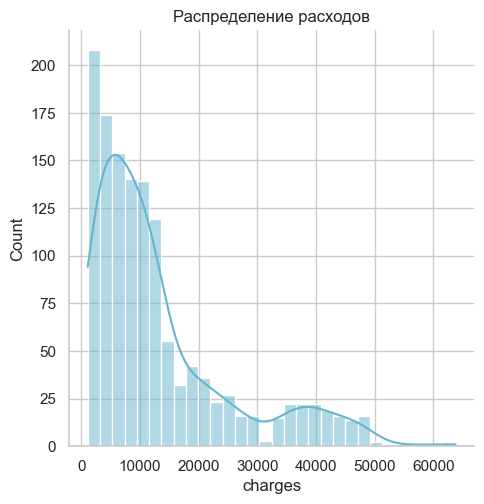

In [11]:
sns.set(style='whitegrid')
ax = sns.displot(df['charges'], kde = True, color = 'c')
plt.title('Распределение расходов')

По графику сверху заметно, что распределение асимметрично. Больше всего людей платят в районе 10000 долларов за страховку.

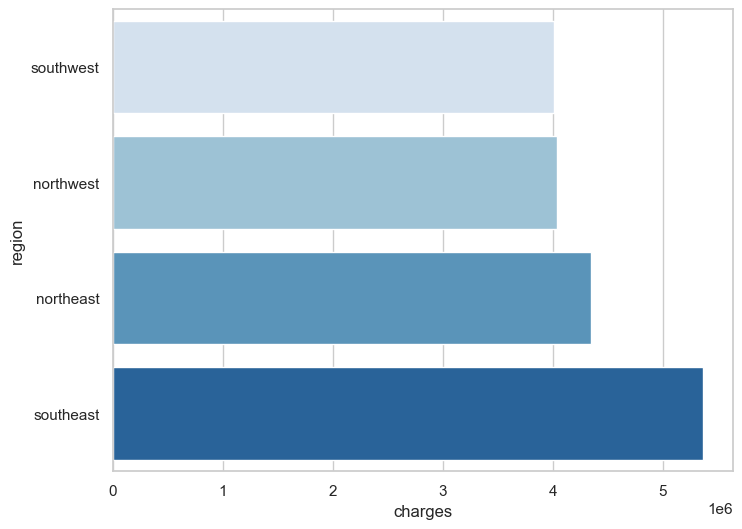

In [12]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x=charges.head(), y=charges.head().index, palette='Blues')

Понятно, что больше всего расходов среди людей из юго-востока, а меньше всего - на юго-западе. Посмотрим на это в зависимости от пола, курения и количества детей.

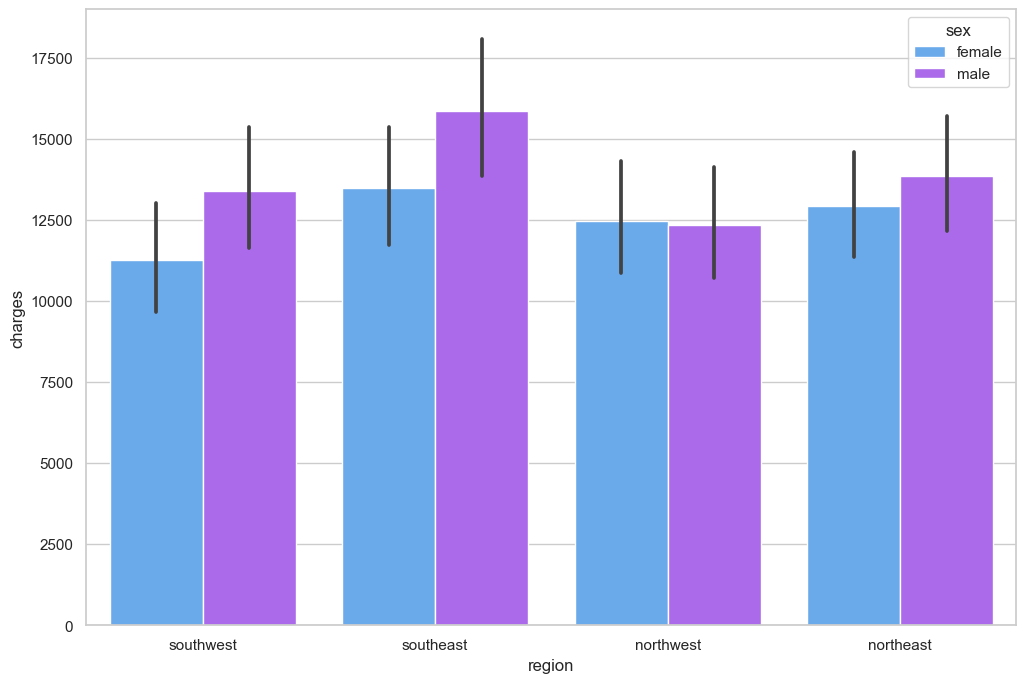

In [13]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

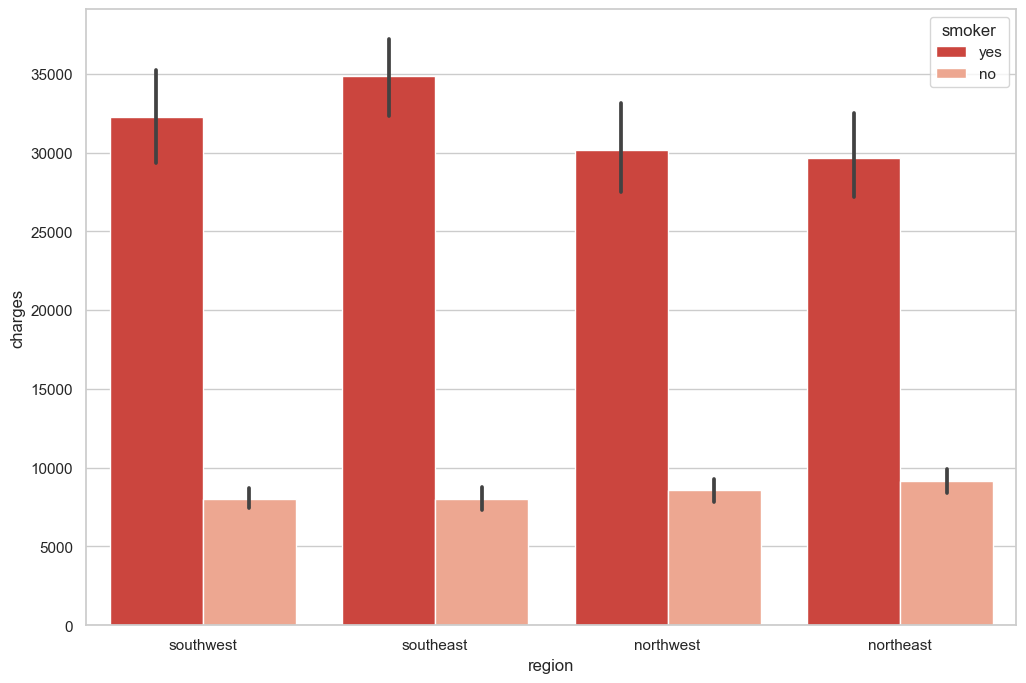

In [14]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df, palette='Reds_r')

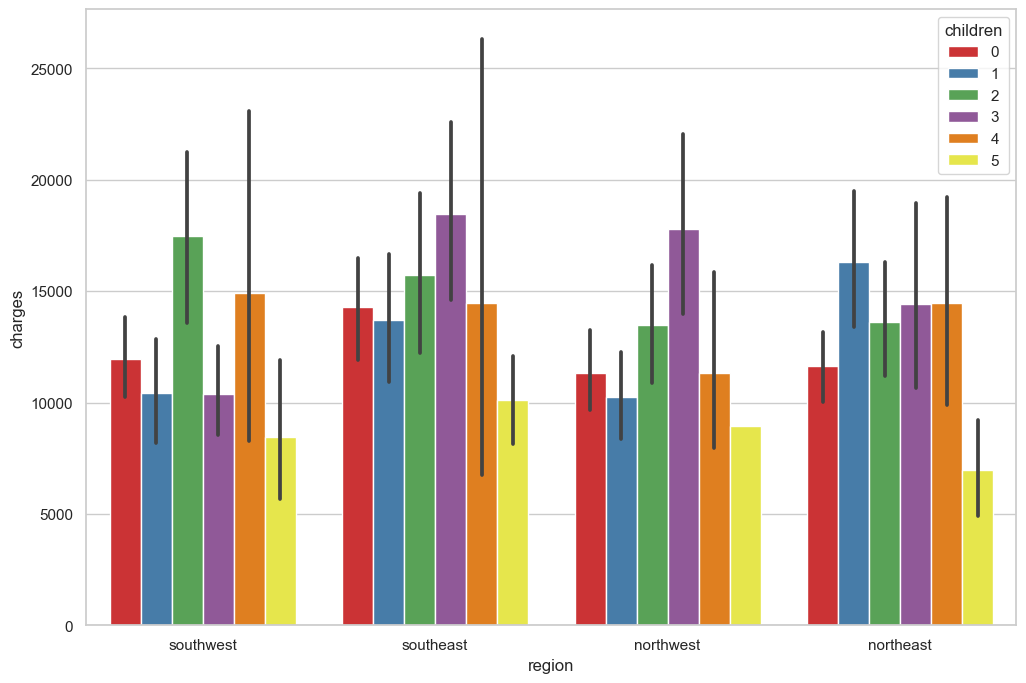

In [15]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')

Из этих диаграмм можно сделать следующие выводы:
- Курящие имеют большие расходы, чем некурящие
- На юго-востоке курящие имеют самые большие расходы, а на северо-востоке - самые низкие
- На юго-востоке мужчины больше всего платят, там же больше всего платят курящие люди
- У людей с детьми, как правило, больше расходов, чем у людей без детей

Кажется логичным, что курящие вынуждены больше платить за медицинскую страховку. Посмотрим на показатели расходов в зависимости от возраста, индекса массы тела и количества детей, но теперь деля по признаку курения.

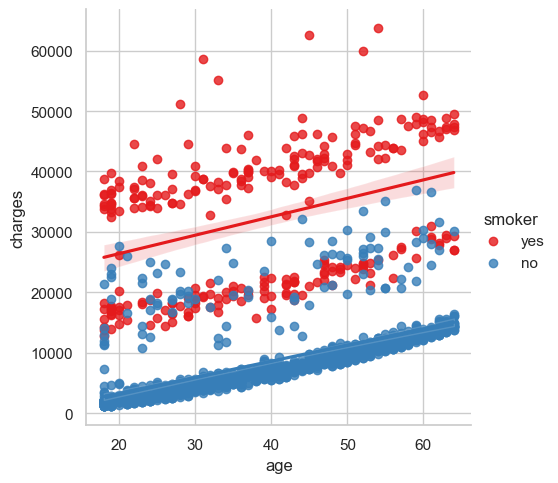

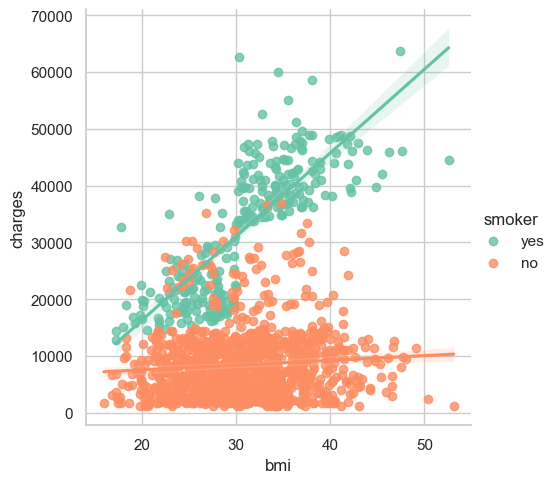

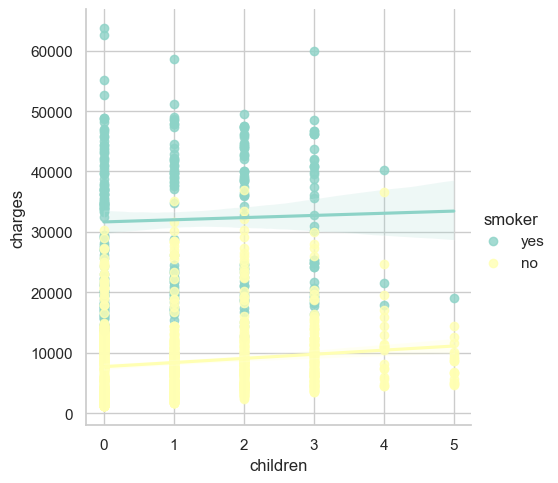

In [16]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

Можно сделать следующие выводы:
- Количество расходов растет с увеличением возраста, индекса массы тела и количества детей
- Среди курящих гораздо меньше тех, у кого есть дети
- У курящих людей расходы очень сильно повышаются. Можно сказать, что пристрастие к курению дает наибольший эффект на медицинские расходы

Последние 2 пункта можно более наглядно продемонстрировать через диаграмму скрипок:

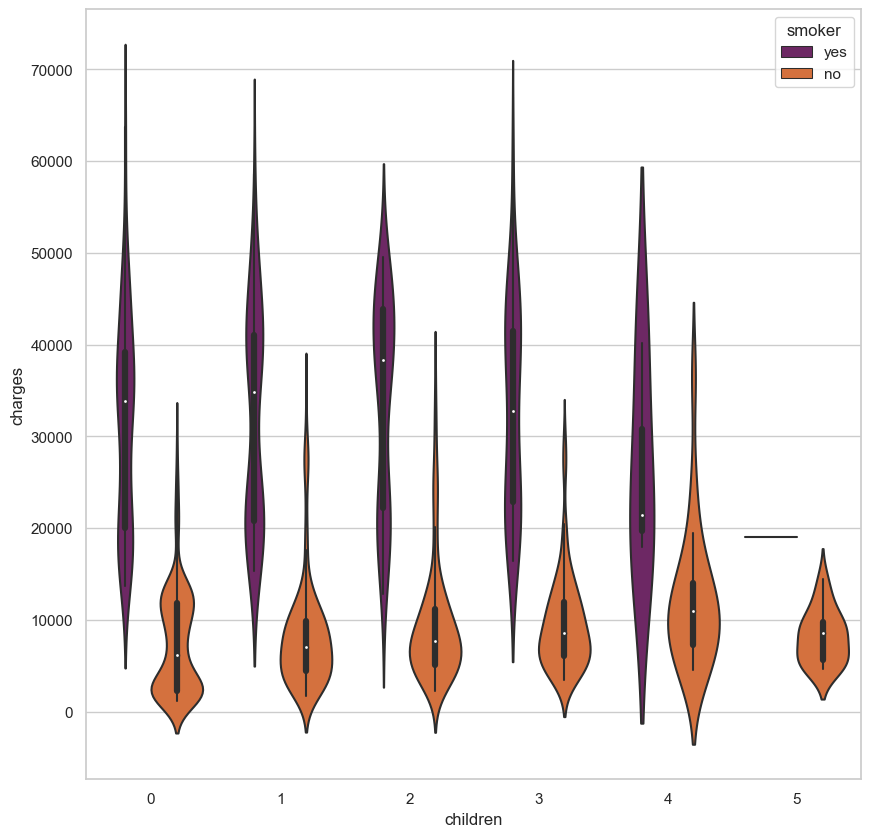

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df, orient='v', hue='smoker', palette='inferno')

Заметим, что у нас есть 3 категориальных признака: пол, курение и регион. Мы можем преобразовать их закодировать:

In [18]:
numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical_columns = ['sex', 'children', 'smoker', 'region']

label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Теперь мы можем построить диаграмму корреляции

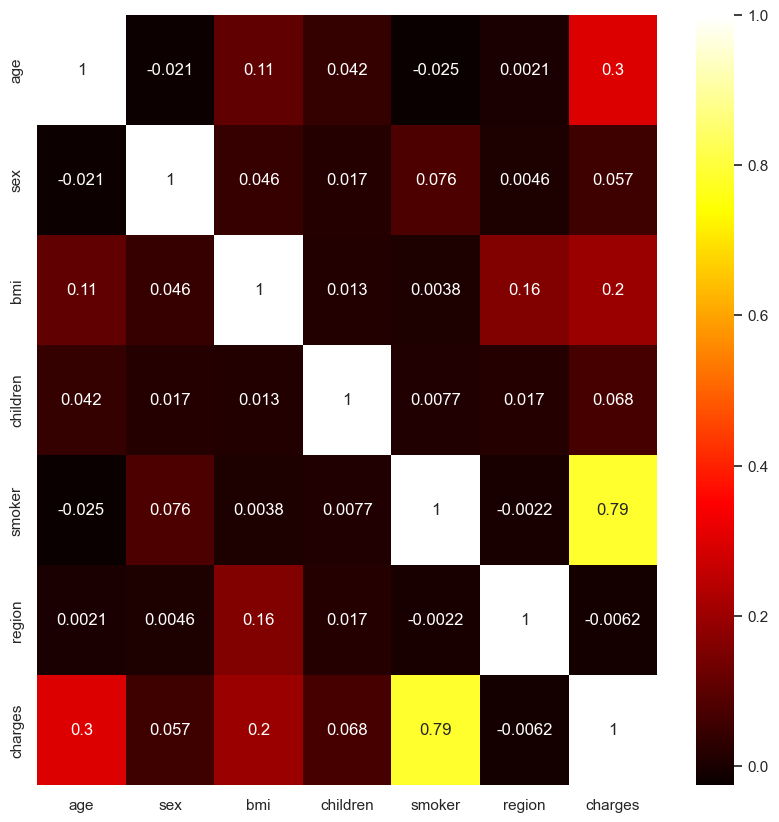

In [19]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='hot')

Можно заметить, что наибольшая корреляция наблюдается между курением и количеством расходов. Также заметна корреляция между возрастом и расходами, между индексом массы тела и расходами.

# Разбиение выборки на обучающую и тестовую

In [20]:
x = df.drop(['charges'], axis=1)
y = df['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Масштабирование признаков

In [21]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# Переведем в dataframe
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,age,sex,bmi,children,smoker,region
0,0.472227,-1.024602,-1.756525,0.734336,-0.508747,-0.456116
1,0.543313,-1.024602,-1.033082,-0.911192,-0.508747,-1.353256
2,0.898745,-1.024602,-0.943687,-0.911192,-0.508747,0.441024
3,-0.025379,-1.024602,0.622393,3.202629,-0.508747,0.441024
4,1.040918,-1.024602,-1.504893,1.557100,-0.508747,-0.456116


# Подбор наилучшего количества (и подмножества) признаков

Для того чтобы выбрать параметры, было решено использовать RFECV с линейной регрессией.

In [22]:
rfecv = RFECV(estimator=LinearRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  4
Выбранные признаки:  ['age', 'bmi', 'children', 'smoker']


/Users/Alexander.Bozhnyuk/DataspellProjects/MachineLearning/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


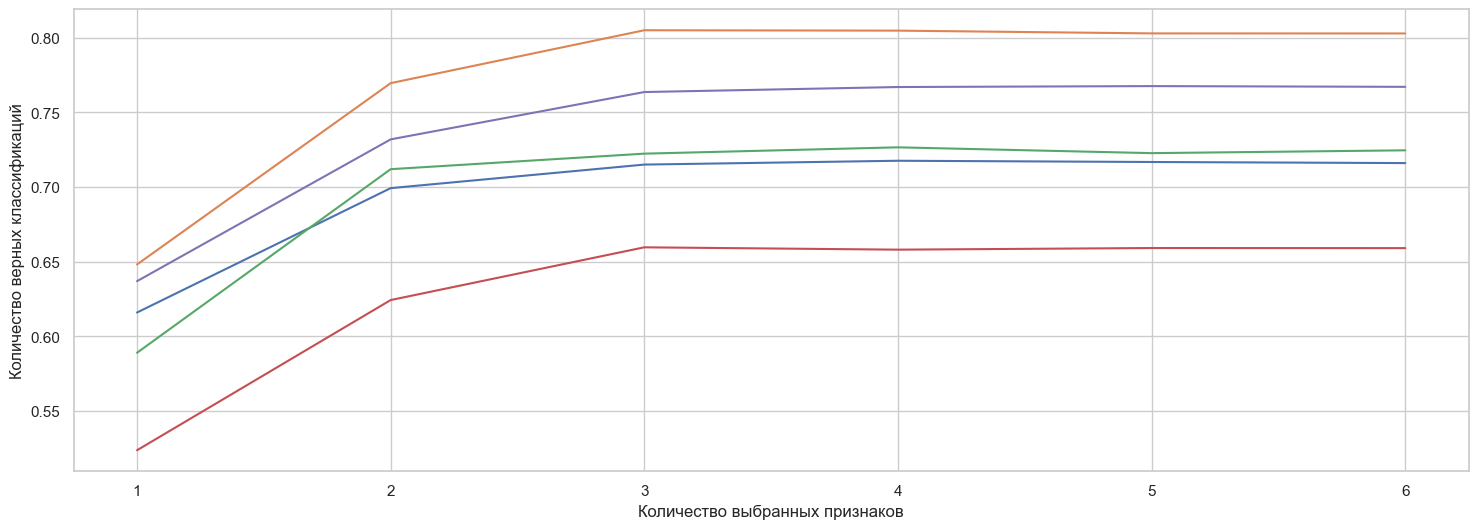

In [23]:
plt.figure(figsize=(18,6))
plt.xlabel("Количество выбранных признаков")
plt.ylabel("Количество верных классификаций")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

В результате подбора выяснилось, что можно избавиться от столбца региона.

In [24]:
x_train_scaled = x_train_scaled.drop(columns=['region'])
x_test_scaled = x_test_scaled.drop(columns=['region'])
x_train_scaled.head()

,age,sex,bmi,children,smoker
0,0.472227,-1.024602,-1.756525,0.734336,-0.508747
1,0.543313,-1.024602,-1.033082,-0.911192,-0.508747
2,0.898745,-1.024602,-0.943687,-0.911192,-0.508747
3,-0.025379,-1.024602,0.622393,3.202629,-0.508747
4,1.040918,-1.024602,-1.504893,1.557100,-0.508747


# Подбор гиперпараметров

In [25]:
alpha_grid = np.logspace(-4, 4, 10)
tol_grid = np.logspace(-4, 4, 10)

searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "tol": tol_grid}], scoring="neg_root_mean_squared_error", cv=5)
_ = searcher.fit(x_train_scaled, y_train)

optimal_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f:", optimal_alpha)

optimal_tol = searcher.best_params_["tol"]
print("Best tol = %.4f", optimal_tol)

Best alpha = %.4f: 2.782559402207126
Best tol = %.4f 0.0001


# Обучение библиотечной модели

In [54]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)

model.fit(x_train_scaled, y_train)
y_train_pred2 = model.predict(x_train_scaled)
y_test_pred2 = model.predict(x_test_scaled)
model.coef_

array([ 3.60610447e+03, -2.18081057e+00,  1.97443855e+03,  5.18868521e+02,
        9.53414382e+03])

Оценим точность предсказания библиотечной линейной регрессии. Как видим, отличий от нашей реализации почти не наблюдается.

In [55]:
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred2))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred2))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred2))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred2))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred2))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred2))

Test RMSE = 5830.6973
Train RMSE = 6113.1277
Test MSE = 33997031.1960
Train MSE = 37370330.8121
Test MAE = 4217.9475
Train MAE = 4213.8607
Test MAPE = 0.4815
Train MAPE = 0.4227
Test R^2 = 0.7810
Train R^2 = 0.7411


# Обучение своей модели градиентного возраста

In [56]:
gradient_model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)
gradient_model.fit(x_train_scaled, y_train)
gradient_model.w

array([ 1.33114729e+04,  3.60610447e+03, -2.18081052e+00,  1.97443855e+03,
        5.18868521e+02,  9.53414382e+03])

Оценим точность предсказания градиентного спуска через разные метрики.

In [27]:
y_train_pred1 = linear_model(gradient_model.w, x_train_scaled)
y_test_pred1 = linear_model(gradient_model.w, x_test_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred1))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred1))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred1))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred1))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred1))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred1))

Test RMSE = 5829.4332
Train RMSE = 6113.2258
Test MSE = 33982291.0823
Train MSE = 37371529.1342
Test MAE = 4208.1308
Train MAE = 4204.8526
Test MAPE = 0.4786
Train MAPE = 0.4203
Test R^2 = 0.7811
Train R^2 = 0.7411


# Обучение своей модели стохастического градиентного спуска

In [47]:
sgd_model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol, iterations_cnt=4000)
sgd_model.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
sgd_model.w

array([[3039.39589922],
       [ 492.5411594 ],
       [ -69.02889889],
       [ 869.71191057],
       [ 137.05313307],
       [1574.69601189]])

Оценим точность предсказания стохастического градиентного спуска через разные метрики.

In [119]:
y_train_pred3 = linear_model(sgd_model.w, x_train_scaled)
y_test_pred3 = linear_model(sgd_model.w, x_test_scaled)
y_test_pred3 = y_test_pred3.reshape(y_test_pred3.shape[0],)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred3, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred3, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred3, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred3, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred3))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred3))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred3))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred3))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred3))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred3))

Test RMSE = 14701.0182
Train RMSE = 14729.4349
Test MSE = 216119934.8804
Train MSE = 216956252.8050
Test MAE = 9955.5282
Train MAE = 10357.4147
Test MAPE = 0.6678
Train MAPE = 0.6976
Test R^2 = -0.3921
Train R^2 = -0.5032


Мы получили результаты, которые очень сильно хуже других моделей. Проблема в том, что стохастический градиентный спуск сходится очень медленно, поэтому дождаться сходимости через условие остановки очень сложно. Пришлось добавить параметр для ограничения количества итераций, чтобы получить хоть какие-то результаты.

# Обучение своей модели мини-пакетного градиентного спуска

In [52]:
mini_batch_model = MiniBatchGDLinearRegression(batch_size=x_train_scaled.shape[0] // 50)
mini_batch_model.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
mini_batch_model.w

array([4702.60602997,  902.25862764, 2624.5399893 ,  441.76654249,
       7728.72243835])

Оценим точность предсказания мини-пакетного градиентного спуска через разные метрики.

In [53]:
y_train_pred4 = np.dot(x_train_scaled, mini_batch_model.w) + mini_batch_model.cost
y_test_pred4 = np.dot(x_test_scaled, mini_batch_model.w) + mini_batch_model.cost

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred4, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred4, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred4, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred4, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred4))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred4))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred4))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred4))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred4))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred4))

Test RMSE = 6402.8109
Train RMSE = 6589.7660
Test MSE = 40995986.8191
Train MSE = 43425016.0637
Test MAE = 4892.1271
Train MAE = 4787.2807
Test MAPE = 0.6057
Train MAPE = 0.5138
Test R^2 = 0.7359
Train R^2 = 0.6991


Видно, что результаты не сильно отличаются от библиотечной модели

Если мы построим графики оценки MPE для двух предсказателей, то увидим, что они почти не отличимы.

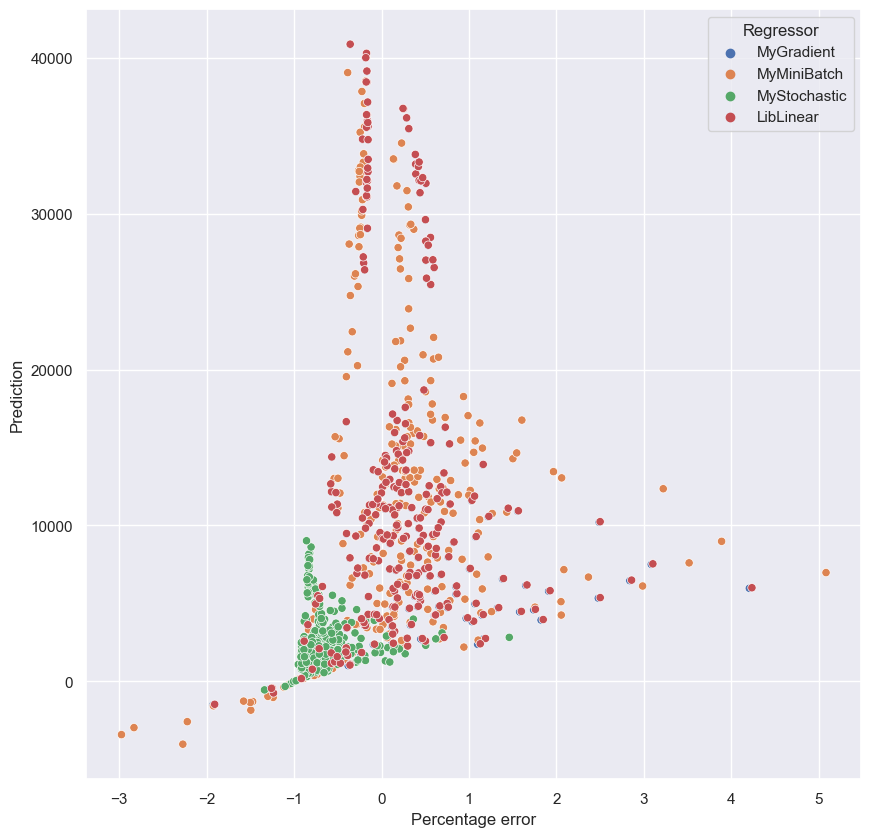

In [118]:
df1=pd.DataFrame({'Prediction': y_test_pred1, 'Percentage error': (y_test_pred1 - y_test)/y_test, "Regressor":"MyGradient"},
                 columns=['Prediction', 'Percentage error', "Regressor"])
df2=pd.DataFrame({'Prediction': y_test_pred4, 'Percentage error': (y_test_pred4 - y_test)/y_test,
                  "Regressor":"MyMiniBatch"}, columns=['Prediction', 'Percentage error','Regressor'])
df3=pd.DataFrame({'Prediction': y_test_pred3, 'Percentage error': (y_test_pred3 - y_test)/y_test,
                  "Regressor":"MyStochastic"}, columns=['Prediction', 'Percentage error','Regressor'])
df4=pd.DataFrame({'Prediction': y_test_pred2, 'Percentage error': (y_test_pred2 - y_test)/y_test,
                  "Regressor":"LibLinear"}, columns=['Prediction', 'Percentage error','Regressor'])


sns.set(rc={'figure.figsize':(10,10)})
rbf_poly_scatter=sns.scatterplot(data=pd.concat([df1, df2, df3, df4]),y="Prediction", x="Percentage error", hue='Regressor')


Можно увидеть, что мои реализации в плане предсказательной способности практически не отличаются от библиотечной реализации (кроме стохастического градиентного спуска)

# Кросс-валидация и таблица результатов

Построим результаты для реализации градиентного спуска

In [64]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train, cur_y_train)
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.675900e+07,3.887028e+07,3.784412e+07,3.513760e+07,3.798876e+07,3.731995e+07,1.432034e+06
mse-test,4.002669e+07,3.164726e+07,3.591237e+07,4.651143e+07,3.513653e+07,3.784686e+07,5.686597e+06
rmse-train,6.062920e+03,6.234604e+03,6.151757e+03,5.927698e+03,6.163502e+03,6.108096e+03,1.178607e+02
rmse-test,6.326665e+03,5.625590e+03,5.992693e+03,6.819929e+03,5.927608e+03,6.138497e+03,4.551272e+02
r2-train,7.466655e-01,7.212460e-01,7.440995e-01,7.599481e-01,7.338171e-01,7.411552e-01,1.451234e-02
r2-test,7.165991e-01,8.047571e-01,7.229444e-01,6.584234e-01,7.660764e-01,7.337601e-01,5.516341e-02


Построим результаты для библиотечной модели

In [63]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)
results_ridge = pd.DataFrame(index=[
    'mse_train', 'mse_test', 'rmse_train',  'rmse_test', 'r2_train', 'r2_test'
])

mse_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
mse_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="neg_mean_squared_error")
rmse_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
rmse_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="neg_root_mean_squared_error")
r2_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="r2")
r2_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="r2")

for fold_i in range(5):
    results_ridge.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        -mse_train[fold_i], -mse_test[fold_i], -rmse_train[fold_i], -rmse_test[fold_i], r2_train[fold_i], r2_test[fold_i]
    ])

E = results_ridge.mean(axis=1)
std = results_ridge.std(axis=1)
results_ridge["E"] = E
results_ridge["STD"] = std
results_ridge

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse_train,3.999973e+07,3.168069e+07,3.592262e+07,4.650673e+07,3.511289e+07,3.784453e+07,5.675102e+06
mse_test,2.638492e+07,3.599929e+07,3.993535e+07,4.027366e+07,3.679708e+07,3.587806e+07,5.629431e+06
rmse_train,6.324534e+03,5.628560e+03,5.993548e+03,6.819584e+03,5.925613e+03,6.138368e+03,4.541076e+02
rmse_test,5.136625e+03,5.999941e+03,6.319442e+03,6.346153e+03,6.066060e+03,5.973644e+03,4.919788e+02
r2_train,7.167900e-01,8.045508e-01,7.228653e-01,6.584579e-01,7.662338e-01,7.337796e-01,5.509756e-02
r2_test,8.442879e-01,7.190738e-01,7.444257e-01,6.846574e-01,8.100247e-01,7.604939e-01,6.557384e-02


In [120]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,4.231577e+07,4.528363e+07,4.438861e+07,4.163116e+07,4.350590e+07,4.342502e+07,1.486424e+06
mse-test,4.786199e+07,3.599057e+07,3.957063e+07,5.060042e+07,4.310147e+07,4.342502e+07,5.945694e+06
rmse-train,6.505058e+03,6.729311e+03,6.662478e+03,6.452222e+03,6.595900e+03,6.588994e+03,1.127924e+02
rmse-test,6.918236e+03,5.999214e+03,6.290519e+03,7.113397e+03,6.565171e+03,6.577307e+03,4.528276e+02
r2-train,7.083696e-01,6.752534e-01,6.998459e-01,7.155857e-01,6.951591e-01,6.988427e-01,1.534698e-02
r2-test,6.611228e-01,7.779617e-01,6.947217e-01,6.283942e-01,7.130493e-01,6.950499e-01,5.655194e-02


Построим результаты для мини-пакетного градиентного спуска

In [62]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = MiniBatchGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = np.dot(cur_x_train, mini_batch_model.w) + mini_batch_model.cost
    y_predf_test = np.dot(cur_x_test, mini_batch_model.w) + mini_batch_model.cost

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,4.231577e+07,4.528363e+07,4.438861e+07,4.163116e+07,4.350590e+07,4.342502e+07,1.486424e+06
mse-test,4.786199e+07,3.599057e+07,3.957063e+07,5.060042e+07,4.310147e+07,4.342502e+07,5.945694e+06
rmse-train,6.505058e+03,6.729311e+03,6.662478e+03,6.452222e+03,6.595900e+03,6.588994e+03,1.127924e+02
rmse-test,6.918236e+03,5.999214e+03,6.290519e+03,7.113397e+03,6.565171e+03,6.577307e+03,4.528276e+02
r2-train,7.083696e-01,6.752534e-01,6.998459e-01,7.155857e-01,6.951591e-01,6.988427e-01,1.534698e-02
r2-test,6.611228e-01,7.779617e-01,6.947217e-01,6.283942e-01,7.130493e-01,6.950499e-01,5.655194e-02


# Выводы

Мы имеем, что написанная модель линейной регрессии с градиентным спуском и мини-пакетным градиентным спуском почти полностью совпадает по точности с моделью Ridge библиотеки sklearn.
Причем совпадение наблюдается как до, так и после кроссвалидации.